# Dataloader for Contrastive Loss

This notebook implements the dataloader needed for training the Siamese network later.

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1" #to suppress some unnecessary warnings
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from DataLoaders import DataLoaderContrastive, DataLoaderTriplet, get_dataset_contrastive_with_prefetching
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Scan the directories of the dataset

In [4]:
dataset_root_path = os.path.join('Data', 'Casia Webface', 'casia-webface')
classes_paths = []

# scan all classes directories
for class_dir in os.scandir(dataset_root_path):

    files = os.listdir(class_dir.path)
    classes_paths.append([])

    for file in files:
        classes_paths[-1].append(os.path.join(class_dir.path, file))

print(f"{len(classes_paths)} classes")

10572 classes


## Triplet DataLoader

In [5]:
train_loader = DataLoaderTriplet(dataset_root_path=dataset_root_path, batch_size=6, img_size=(112, 112))

In [6]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    for i in range(len(anchor)):
        plt.figure(i)

        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.imshow(positive[i])
        plt.title("positive")

        plt.subplot(1, 3, 2)
        plt.axis('off')
        plt.imshow(anchor[i])
        plt.title("anchor")

        plt.subplot(1, 3, 3)
        plt.axis('off')
        plt.imshow(negative[i])
        plt.title("negative")

(X1, X2, X3), _ = train_loader[random.randint(0, len(train_loader)-1)]
visualize(X1, X2, X3)

I0000 00:00:1734367868.720110    7846 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5741 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


ValueError: too many values to unpack (expected 2)

## Contrastive DataLoader

### with 20% positive pairs / 80% negative pairs (can be tuned)

In [7]:
# notice (positive_ratio=0.2) for 20% of positive pairs and 80% of negative pairs for each batch
train_loader = DataLoaderContrastive(dataset_root_path=dataset_root_path, batch_size=4, positive_ratio=0.2, img_size=(112, 112))

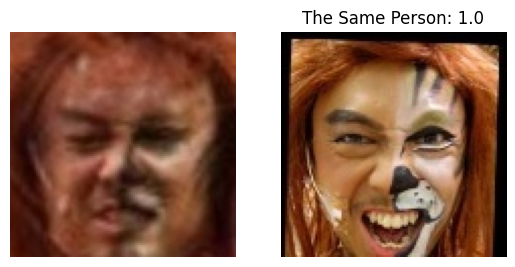

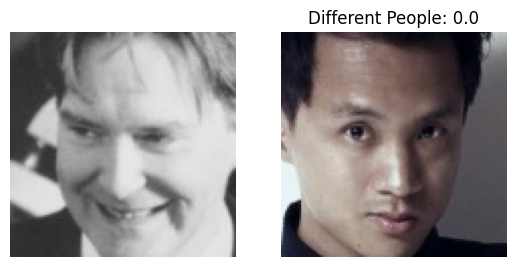

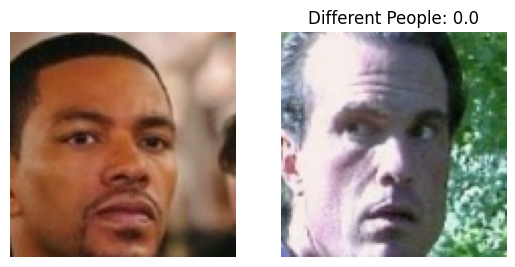

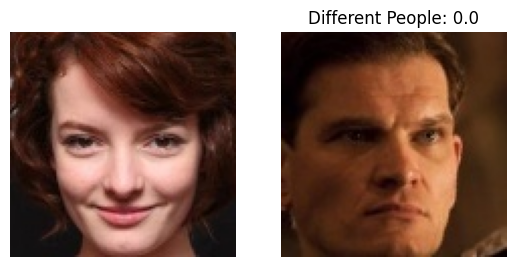

In [8]:
# get sample batch
(X1, X2), Y = train_loader[random.randint(0, len(train_loader)-1)]

# show the whole batch
for i in range(len(X1)):

    x1 = X1[i]
    x2 = X2[i]
    y_label = Y[i]

    plt.figure(i)

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(x1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(x2)

    if y_label[0] == 1:
        plt.title("The Same Person: " + str(y_label[0]))
    else:
        plt.title("Different People: " + str(y_label[0]))

plt.show()

## Test on Real Example

### Create a Test Model

In [9]:
Input1 = keras.layers.Input(shape = (112, 112, 3))
Input2 = keras.layers.Input(shape = (112, 112, 3))
flatten1 = keras.layers.Flatten()(Input1)
flatten2 = keras.layers.Flatten()(Input2)
feature_vector = keras.layers.Concatenate()([flatten1, flatten2])
clf_head = keras.layers.Dense(256, 'relu')(feature_vector)
output = keras.layers.Dense(1, 'sigmoid')(clf_head)

model = keras.Model(inputs = [Input1, Input2], outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


### Train the Model

In [ ]:
train_loader = get_dataset_contrastive_with_prefetching(dataset_root_path=dataset_root_path, batch_size=512, positive_ratio=0.5, image_size=(112, 112))

model.fit(train_loader, epochs = 10)

### Test the Model on an Example (After being Trained)

In [70]:
# sample random batch
(X1, X2), y = train_loader[random.randint(0, len(train_loader)-1)]

# sample random pair
n = random.randint(0, X1.shape[0]-1)
x1, x2, y = X1[n], X2[n], y[n]

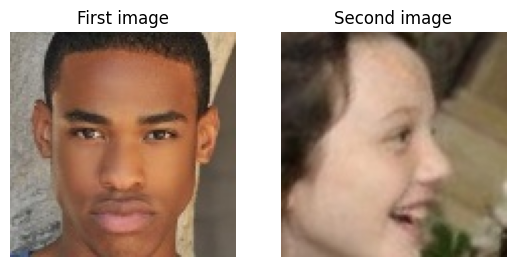

In [71]:
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

In [72]:
y_pred = model.predict(x = [np.expand_dims(x1, axis = 0), np.expand_dims(x2, axis = 0)])

print(f"Prediction is: {y_pred[0]}, true label is: {y[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Prediction is: [0.50015604], true label is: 0.0


## Optimize the data loader using tensorflow prefetching

In [16]:
# This is how to turn the regular dataloader into a tensorflow dataset with prefetching enabled
#
#  dataset = tf.data.Dataset.from_generator(
#         DataLoader, 
#         args = [dataset_root_path, 32, (112, 112)], 
#         output_signature = ((tf.TensorSpec(shape = (32, 112, 112, 3), dtype = tf.float32), tf.TensorSpec(shape = (32, 112, 112, 3), dtype = tf.float32)), tf.TensorSpec(shape = (32, 1), dtype = tf.float32))
#  ).prefetch(tf.data.AUTOTUNE)


# Use the function implemented in the Utilities file instead
dataset = get_dataset_with_prefetching(dataset_root_path=dataset_root_path, batch_size=32, positive_ratio=0.4, image_size=(112, 112))
model.fit(dataset, epochs = 3)

Epoch 1/3
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5251 - loss: 0.7647
Epoch 2/3
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5424 - loss: 0.7263
Epoch 3/3
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5386 - loss: 0.7177
